In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pyvisa import VisaIOError, ResourceManager

from pylabnet.hardware.oscilloscopes.tektronix_tds2004C import Driver
from pylabnet.network.client_server.tektronix_tds2004C import Client

# Connect to Client

In [2]:
scope = Client(
    host='192.168.0.17',
    port=2253
)

# Triggering

The goal is to measure the following digital pulse sequence. Channels 1 - 3 should measure this sequence, CH4 is used as trigger channel.

![alt text](pictures/pulse_seq.png "Title")

We know that we want to measure a rounghly 5$\mu$s long sequence of 0 - 3.3 V TTL signals. The trigger signal is connected to CH4, and triggering is done on a raising edge of a TTL signal. We'll use this knowledge to setup the scope correctly.

In [3]:
# Find out which trigger source is set.
scope.get_trigger_source()

'CH1'

In [4]:
# Set trigger source to CH4.
scope.set_trigger_source('CH4')
scope.get_trigger_source()

'CH4'

In [5]:
# Let's set the timebase accordingly
timespan = 1e-6 # 1us per div --> total window of 10us
scope.set_timing_scale(timespan)

# Let's set the scales accordingly (we expect signal from 0 to 3.3V)
for channel in ['CH1', 'CH2', 'CH3', 'CH4']:
    
    # Set scale to 1V/div, with 10 divs this gives us a range of 10V.
    scope.set_channel_scale(channel, 1)
    
    # Set the zero horizontal position to 0V.
    scope.set_channel_pos(channel, 0)


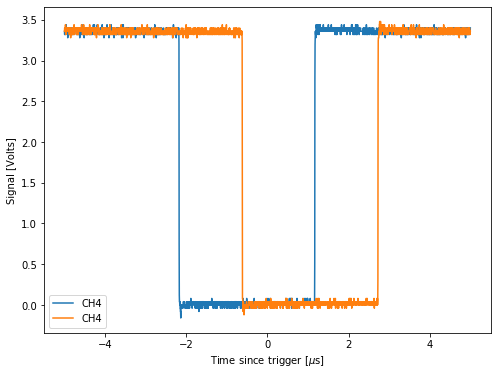

In [6]:
# Let's have a look at the trigger trace.
# We plot two subsequent acquisitions and see that we are not triggering correctly.
scope.plot_traces(['CH4'], reps=2)

In [7]:
# Let's set the trigger level to 50%.
scope.trig_level_to_fifty()

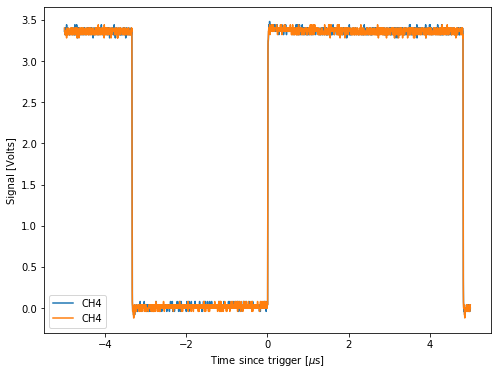

In [8]:
# Triggering now works.
scope.plot_traces(['CH4'], reps=2)

# Adjustment of horizontal and vertical settings

A standard scope-workflow involves setting horizontal and vertical ranges and scalings using the various knobs. This section shows how this is done programatically.

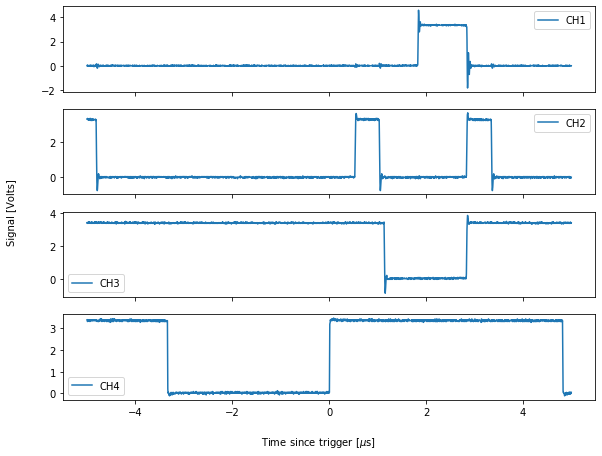

In [9]:
# Plot all traces.
scope.plot_traces(['CH1', 'CH2', 'CH3', 'CH4'])

Note how the origin of the time axis coincides witht the raising edge of our trigger signal. We can see that the entire pulse sequence takes roughly 4 $\mu$ s, we can thus use the horizontal scale function to further restrict the acquisition to a interesting time window.

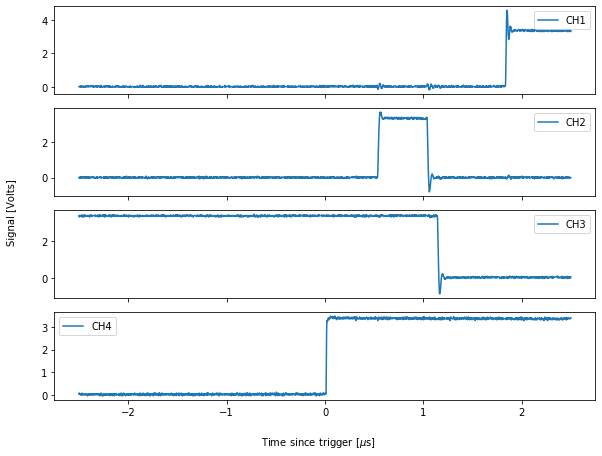

In [10]:
# Set timebase to 500ns / div.
scope.set_timing_scale(500e-9 )
scope.plot_traces(['CH1', 'CH2', 'CH3', 'CH4'])

Finally, let's move the horizontal position such that the waveform starts at the leftmost x-value.

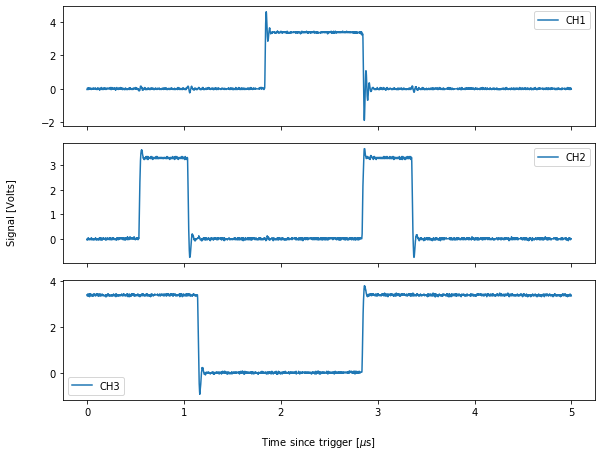

In [11]:
# Let's move the trace 2.5 us to the right.
scope.set_horizontal_position(+2.5e-6)
scope.plot_traces(['CH1', 'CH2', 'CH3'])

![alt text](pictures/pulse_seq.png "Title")

This looks good, now we can measure the entire waveform. Let's say we're interested in the relative timing between CH2 and CH3. We can easily plot it in one plot using the `staggered=False` argument:

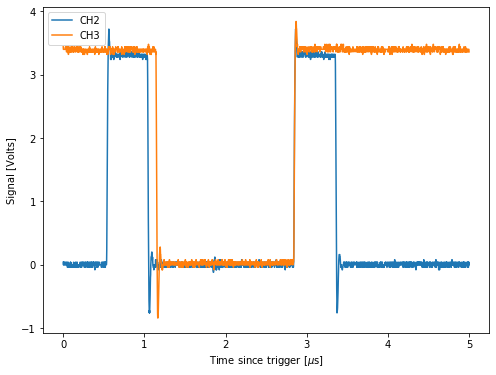

In [12]:
scope.plot_traces(['CH2', 'CH3'], staggered=False)

We can also easily access the raw trace data:

In [13]:
scope.read_out_trace('CH1', curve_res=1)

{'trace': array([0.04, 0.04, 0.04, ..., 0.04, 0.  , 0.  ]),
 'ts': array([0.000e+00, 2.000e-09, 4.000e-09, ..., 4.994e-06, 4.996e-06,
        4.998e-06]),
 'x_unit': 's',
 'y_unit': 'Volts'}

# Additional commands

In [14]:
# Generic GPIB command:

# Example query.
scope.query('TRIGger:MAIn:MODe?')

':TRIGGER:MAIN:MODE AUTO\n'

In [15]:
# Example write.
scope.write('TRIGger:MAIn:EDGE:SLOpe RISE')

(30, <StatusCode.success: 0>)

In [16]:
# Get and set trigger level.
scope.set_trigger_level(0.6)
scope.get_trigger_level()

0.6

In [17]:
# Set and get horizontal position in s.
scope.set_horizontal_position(5e-6)
scope.get_horizontal_position()

5e-06

In [18]:
# Get vertical channel position (in divs).
scope.set_channel_pos('CH1', 1)
scope.get_channel_pos('CH1')

1.0

In [19]:
# Get vertical channel scale (in V/div).
scope.set_channel_scale('CH1', 0.2)
scope.get_channel_scale('CH1')

0.2

In [20]:
# Get and set channel attenuation setting.
scope.set_channel_attenuation('CH1', 100)
scope.get_channel_attenuation('CH1')

100.0